# Pairwise Fst between populations

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '10g'}, tmp_dir='/home/olavur/tmp')

Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-7889d4ff4c-6wxtc:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/gnomad_exome_sites/hail-20210409-1241-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [3]:
import numpy as np
import pandas as pd
from seaborn import clustermap

In [4]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'

## Load merged FarGen and gnomAD allele frequency data

In [5]:
af_ht = hl.read_table(BASE_DIR + '/data/resources/gnomad_exome_sites/fargen_gnomad_union_filtered.ht')

In [6]:
n_variants = af_ht.count()
print('Number of variants: ' + str(n_variants))

Number of variants: 15953417


## Reduction in heterozygosity due to population subdivision, Fst

**TODO:** How do I aggregate $F_{st}$ values across loci? Is ther a better way than using the mean $F_{st}$?

**NOTE:** There are way more advanced methods of calculating population subdivision than the simple $F_{st}$.

Given two populations having allele frequencies $p_1$ and $p_2$ at some locus, we define the the fixation index, the reduction of heterozygosity due to population subdivision, as

$$
F_{ST} = \frac{H_T - H_S}{H_T}
$$

where $H_T = 2\bar p (1 - \bar p)$ is the heterozygosity in the total population, where the allele frequency is averaged over subpopulations, and $H_S = \frac{1}{n} \sum_{i=1}^n 2 p_i (1 - p_i)$ is the average heterozygosity in the subpopulations.

In [14]:
def calc_Fst(ht, af1_exprs, af2_exprs):
    '''
    Input:
    ht:            HailTable or MatrixTable
    af1_exprs:     Float64Expression, allele frequency in population 1.
    af2_exprs:     Float64Expression, allele frequency in population 2.
    
    Returns:
    Float, Fst averaged over all sites where total heterozygosity is greater than zero.
    '''
    # Allele frequency in total population is the average of the two fequencies.
    avg_allele_freq_exprs = (af1_exprs + af2_exprs) / 2

    # Calculate HWE expected heterozygosity of total population, usually noted as H_t.
    total_heterozygosity_exprs = 2 * avg_allele_freq_exprs * (1 - avg_allele_freq_exprs)

    # Calculate the average of the expected heterozygosities in the subpopulations, H_s.
    avg_subpop_heterozygosity_exprs = af1_exprs * (1 - af1_exprs) + af2_exprs * (1 - af2_exprs)

    # Calculate reduction in heterozygosity due to subdivision.
    Fst_exprs = (total_heterozygosity_exprs - avg_subpop_heterozygosity_exprs) / total_heterozygosity_exprs

    # Calculate the mean Fst between the two populations.
    # Fst is not defined where the total heterozygosity is 0, as it is infinite, so we do not include such sites in the mean.
    Fst = ht.aggregate(hl.agg.filter(total_heterozygosity_exprs != 0, hl.agg.mean(Fst_exprs)))
    
    return Fst

Calculate the Fst between the Faroese population and the entire gnomAD population.

In [22]:
%%time

Fst = calc_Fst(af_ht, af_ht.fae, af_ht.gnomad_all)

print('Reduction in heterozygosity between FarGen and gnomAD (all) populations: {Fst:.5f}'.format(Fst=Fst))

Reduction in heterozygosity between FarGen and gnomAD (all) populations: 0.00676
CPU times: user 11.8 ms, sys: 3.63 ms, total: 15.5 ms
Wall time: 15.9 s


### Pairwise Fst

A list of populations to use.

In [28]:
pop_list = ['fae', 'afr', 'sas', 'amr', 'eas', 'nfe', 'fin', 'nfe_nwe', 'nfe_seu']

pop_name_list = ['Faroese', 'African', 'SE Asian', 'American', 'E Asian', 'European', 'Finnish', 'NW European', 'S European']

n_pops = len(pop_list)

We will populate a numpy array with Fst values.

In [34]:
pairwise_fst = np.zeros((n_pops, n_pops))

In [40]:
%%time
for i in range(n_pops):
    for j in range(i + 1, n_pops):
        pop1 = pop_list[i]
        pop2 = pop_list[j]
        #print(pop1, pop2)
        
        af1_exprs = af_ht.row_value[pop1]
        af2_exprs = af_ht.row_value[pop2]
        
        pairwise_fst[i,j] = calc_Fst(af_ht, af1_exprs, af2_exprs)

CPU times: user 583 ms, sys: 36.6 ms, total: 620 ms
Wall time: 7min 59s


We have only calculated the upper triangular of this matrix. As it should be symmetric, we can add the transpose to the matrix to obtain the full matrix.

In [41]:
pairwise_fst_sym = pairwise_fst + pairwise_fst.T

We are not interested in seeing the diagonal in the plot, so we remove this.

In [42]:
mask_diag = np.zeros(pairwise_fst_sym.shape, dtype=bool)
diag_idx = np.diag_indices_from(mask_diag)
mask_diag[diag_idx] = True

In [43]:
pairwise_fst_pd = pd.DataFrame(pairwise_fst_sym, columns=pop_name_list, index=pop_name_list)

We make a heatmap of the Fst matrix with a dendrogram showing the clustering. Note that the European and North-Western European populations do not contain Finns.

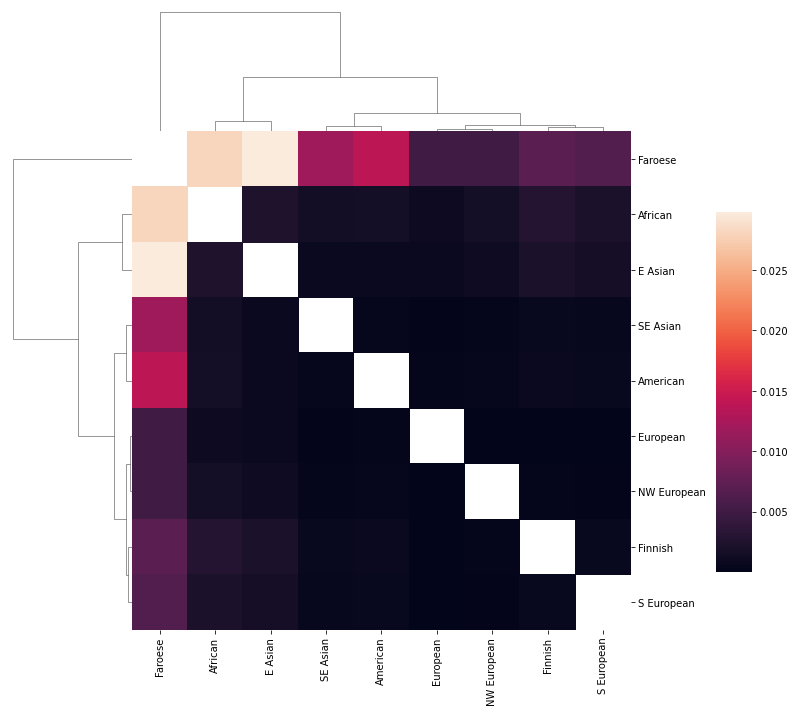

In [44]:
plt = clustermap(pairwise_fst_pd, mask=mask_diag, row_cluster=True, cbar_pos=(1, 0.2, 0.05, 0.5))

Save this plot to file.

In [51]:
plt.savefig(BASE_DIR + '/data/figures/pairwise_Fst_gnomAD.png')

Print the table of Fst values.

In [52]:
pairwise_fst_pd

,Faroese,African,SE Asian,American,E Asian,European,Finnish,NW European,S European
Faroese,0.000000,0.028198,0.011885,0.013900,0.029849,0.005048,0.007050,0.005043,0.006323
African,0.028198,0.000000,0.001497,0.001622,0.002435,0.000958,0.002853,0.001542,0.002121
SE Asian,0.011885,0.001497,0.000000,0.000470,0.000929,0.000235,0.000651,0.000359,0.000505
American,0.013900,0.001622,0.000470,0.000000,0.000902,0.000289,0.000782,0.000442,0.000665
E Asian,0.029849,0.002435,0.000929,0.000902,0.000000,0.000731,0.002157,0.001175,0.001767
European,0.005048,0.000958,0.000235,0.000289,0.000731,0.000000,0.000127,0.000020,0.000093
Finnish,0.007050,0.002853,0.000651,0.000782,0.002157,0.000127,0.000000,0.000267,0.000610
NW European,0.005043,0.001542,0.000359,0.000442,0.001175,0.000020,0.000267,0.000000,0.000201
S European,0.006323,0.002121,0.000505,0.000665,0.001767,0.000093,0.000610,0.000201,0.000000


Write Fst table to file.

In [53]:
pairwise_fst_pd.to_csv(BASE_DIR + '/data/results/pairwise_Fst_gnomAD.csv')